In [1]:
from arc_prize.train import ARCModelState, ARCTrainParams
from arc_prize.vis import visualize_epochs
import modal
import torch
import petname
from arc_prize.model import ARCTransformerEncoderDecoderParams



In [ ]:
from arc_prize.data import ARCDatasetParams, ReARCDataset, make_re_arc_data_loaders

config = ARCDatasetParams(max_grid_size=30, max_train_grids=10, color_offset=1)
dataset = ReARCDataset("data/re_arc/ff805c23.json", config)
train_loader, val_loader = make_re_arc_data_loaders(["data/re_arc/ff805c23.json"], 10, config)
len(val_loader.dataset)


In [3]:
model_type = "normal"

model_params = ARCTransformerEncoderDecoderParams(
  grid_dim=12,
  num_train_pairs=4,
  num_colors=10,
  num_encoder_layers=3,
  num_decoder_layers=3,
  num_heads=4,
  d_model=32,
  d_ff=32*4,
  dropout=0.1
)

train_params = ARCTrainParams(
  batch_size=32,
  learning_rate=1e-4,
  weight_decay=1e-4,
  dataset_dir=["/vol/data/re_arc_dim_12_small"],
  loss_class_weights={0: 0.2}
)

num_epochs = 20

model_names = []

num_runs = 1

fn = modal.Function.lookup("arc-prize", "train")
for i in range(num_runs):
  model_name = petname.generate(words=3, separator='_')
  fn_call = fn.spawn(model_name, num_epochs, model_type, model_params, train_params)
  print("Model name", model_name, model_type, fn_call.object_id)
  model_names.append(model_name)

print(model_names)




Model name simply_holy_loon normal fc-01J9S6G48RG578955BNXN1NTEK
['simply_holy_loon']


In [2]:


from arc_prize.model import ARCTransformerEncoderDecoderParams
from arc_prize.meta import meta_train_on_mac

model_type = "vision"
model_params = ARCTransformerEncoderDecoderParams(
  grid_dim=12,
  num_train_pairs=4,
  num_colors=10,
  num_encoder_layers=1,
  num_decoder_layers=1,
  num_heads=2,
  d_model=16,
  d_ff=16*2,
  dropout=0.1
)

train_params = ARCTrainParams(
  batch_size=20,
  learning_rate=1e-4,
  weight_decay=1e-4,
  dataset_dir=["/Users/pfh/work/arc-data/flip"],
  meta_batch_size=5,
  meta_learning_rate=1e-4,
  meta_weight_decay=1e-4,
  meta_num_epochs=2
)

num_epochs = 10

model_names = []

num_runs = 1


for i in range(num_runs):
  model_name = petname.generate(words=3, separator='_')  
  meta_train_on_mac(model_name, num_epochs, model_type, model_params, train_params)
  # print("Model name", model_name, fn_call.object_id)
  model_names.append(model_name)

print(model_names)




Starting new model truly_happy_yak
Using 0 GPUs in parallel
Model odict_keys(['output_query', 'embedding.conv_embed.weight', 'embedding.conv_embed.bias', 'pos_encoding.row_embedding.weight', 'pos_encoding.col_embedding.weight', 'pos_encoding.input_output_embedding.weight', 'pos_encoding.pair_embedding.weight', 'encoder.layers.0.self_attn.in_proj_weight', 'encoder.layers.0.self_attn.in_proj_bias', 'encoder.layers.0.self_attn.out_proj.weight', 'encoder.layers.0.self_attn.out_proj.bias', 'encoder.layers.0.linear1.weight', 'encoder.layers.0.linear1.bias', 'encoder.layers.0.linear2.weight', 'encoder.layers.0.linear2.bias', 'encoder.layers.0.norm1.weight', 'encoder.layers.0.norm1.bias', 'encoder.layers.0.norm2.weight', 'encoder.layers.0.norm2.bias', 'decoder.layers.0.self_attn.in_proj_weight', 'decoder.layers.0.self_attn.in_proj_bias', 'decoder.layers.0.self_attn.out_proj.weight', 'decoder.layers.0.self_attn.out_proj.bias', 'decoder.layers.0.multihead_attn.in_proj_weight', 'decoder.layers.0.

KeyboardInterrupt: 

In [2]:
model_type = "vision"
model_params = ARCTransformerEncoderDecoderParams(
  grid_dim=12,
  num_train_pairs=4,
  num_colors=10,
  num_encoder_layers=1,
  num_decoder_layers=1,
  num_heads=4,
  d_model=32,
  d_ff=32*4,
  dropout=0.2
)

train_params = ARCTrainParams(
  batch_size=32,
  learning_rate=1e-4,
  weight_decay=1e-4,
  dataset_dir=["/vol/data/move_random_small", "/vol/data/flip"],
  loss_class_weights={0: 0.2},
  meta_num_epochs=2,
  meta_batch_size=10,
  meta_learning_rate=1e-4,
  meta_weight_decay=1e-4,
)

num_epochs = 30

model_names = []

num_runs = 1

fn = modal.Function.lookup("arc-prize-meta", "meta_train")
for i in range(num_runs):
  model_name = petname.generate(words=3, separator='_')
  fn_call = fn.spawn(model_name, num_epochs, model_type, model_params, train_params)
  print("Model name", model_name, model_type, fn_call.object_id)
  model_names.append(model_name)

print(model_names)

Model name weekly_tops_pug vision fc-01J95AXBHJWB0NKC9TMZSC0VJS
['weekly_tops_pug']


In [ ]:
num_epochs = 10

# model_names = ['subtly_moral_bee', 'newly_mint_kite']
model_names = ['lively_fleet_goat']

train_params = ARCTrainParams(
  batch_size=20,
  learning_rate=1e-4,
  weight_decay=1e-4,
  dataset_dir=["/vol/data/html_dim_20_20240925", "/vol/data/move_many_random", "/vol/data/rotate", "/vol/data/scale", "/vol/data/flip"],
  loss_class_weights={0: 0.2}
)
train_params = None

fn = modal.Function.lookup("arc-prize", "train")
for model_name in model_names:
  fn_call = fn.spawn(model_name, num_epochs, None, train_params)
  print("Model name", model_name, fn_call.object_id)
  


In [ ]:
def visualize_group(model_names: list[str]):
  epochs = {}
  get_model = modal.Function.lookup("arc-prize", "get_model")
  for name in model_names:
    checkpoint = ARCModelState(**get_model.remote(name))
    print(name, len(checkpoint.epochs), checkpoint.epochs[-1], checkpoint.model_params)
    epochs[name] = checkpoint.epochs


    # print(len(checkpoint.encoder_attn_weights))
    # for b, batch in enumerate(checkpoint.encoder_attn_weights):
    #   for i, layer in enumerate(batch):
    #     visualize_all_heads(layer, title=f"Batch {b}, layer {i}")
    

  visualize_epochs(epochs)

  


groups = [
  # ['kindly_huge_jennet', 'lovely_tidy_lab', 'solely_living_leech'], # BEST
  # ['weekly_enough_moose', 'gently_known_beagle', 'nicely_robust_rhino'], # 20x20 too slow
  # ['wildly_firm_husky', 'surely_brief_bug', 'fully_better_dodo'], # Amazing
  # ['wildly_steady_iguana', 'yearly_smart_donkey', 'mainly_polite_bison'], # Includes scale dataset
  # ['partly_vocal_piglet', 'neatly_needed_liger', 'firmly_game_weevil'], # Scale and diagonal
  # ['wholly_tops_heron', 'solely_eager_foal', 'deeply_one_skink'], # Tons of data
  # ['unduly_glad_swift', 'purely_steady_hornet', 'humbly_civil_donkey'], # Basic data
  # ["early_civil_beetle"],
  # ["really_fancy_kitten", "mildly_humble_tahr"],
  # ['solely_brief_shad', 'fairly_amazed_hyena', 'vastly_amazed_bobcat'],
  # ['barely_sound_viper', 'lively_key_goblin', 'wildly_fancy_glider'], # patch size 3
  # ['mildly_able_horse', 'vastly_normal_rhino', 'oddly_mint_clam'], # patch size 2
  # ['firmly_tops_adder', 'yearly_normal_puma', 'slowly_more_caiman'], # patch size 2, simpler embedding
  # ['safely_poetic_adder', 'vastly_close_horse', 'fairly_legal_insect', 'daily_actual_monkey'], # Patch embedding with ARC pos encoding
  # ['nicely_wired_mouse', 'freely_up_shrimp', 'hardly_loving_mullet', 'gladly_active_muskox']
  # ['mostly_normal_dog', 'lively_pure_hawk', 'rarely_tender_roughy'], # HUGE dataset re_arc_dim_12
  # ['daily_pro_cattle', 'newly_suited_finch', 'rarely_tender_roughy'], # 32 batch size, 64 dim
  # ['solely_sound_sponge', 'lively_sacred_egret'], # 32 batch size, 128 dim, 3+3 layers
  # ['nicely_pure_leech', 'namely_sure_emu'], # 128 dim, 4+4 layers
  # ['subtly_moral_bee', 'newly_mint_kite', 'solely_busy_skunk'], # Vision transformer large models
  # ['newly_mint_kite', 'namely_caring_mite', 'overly_enough_tomcat', 'subtly_known_panda', 'mildly_ruling_hog', 'simply_tight_fowl'],
  ['subtly_known_panda', 'barely_clean_cicada', 'sadly_real_viper'], # 512 dim (12x12, 20x20, 30x30)
  ['lively_fleet_goat'], # vision 20x20
]

# print([group for sublist in groups for group in sublist])
for group in groups:
  visualize_group(group)

In [ ]:



eval_model = modal.Function.lookup("arc-prize", "evaluate_model")
output = eval_model.remote("lively_fleet_goat", ["/vol/data/eval_dim_20"])
# output = eval_model.remote("overly_hip_egret", ["/vol/data/re_arc/00d62c1b.json"], True, 1)


In [5]:
fn = modal.Function.lookup("arc-prize-meta", "finetune_and_predict")
output = fn.remote("yearly_smart_caiman", ["/vol/data/move_random_small"])

In [6]:
import numpy as np

correct = 0
for item in output:
    if np.array_equal(item["output_grid"], item["predictions"]) is True:
        correct += 1

print(correct)

0


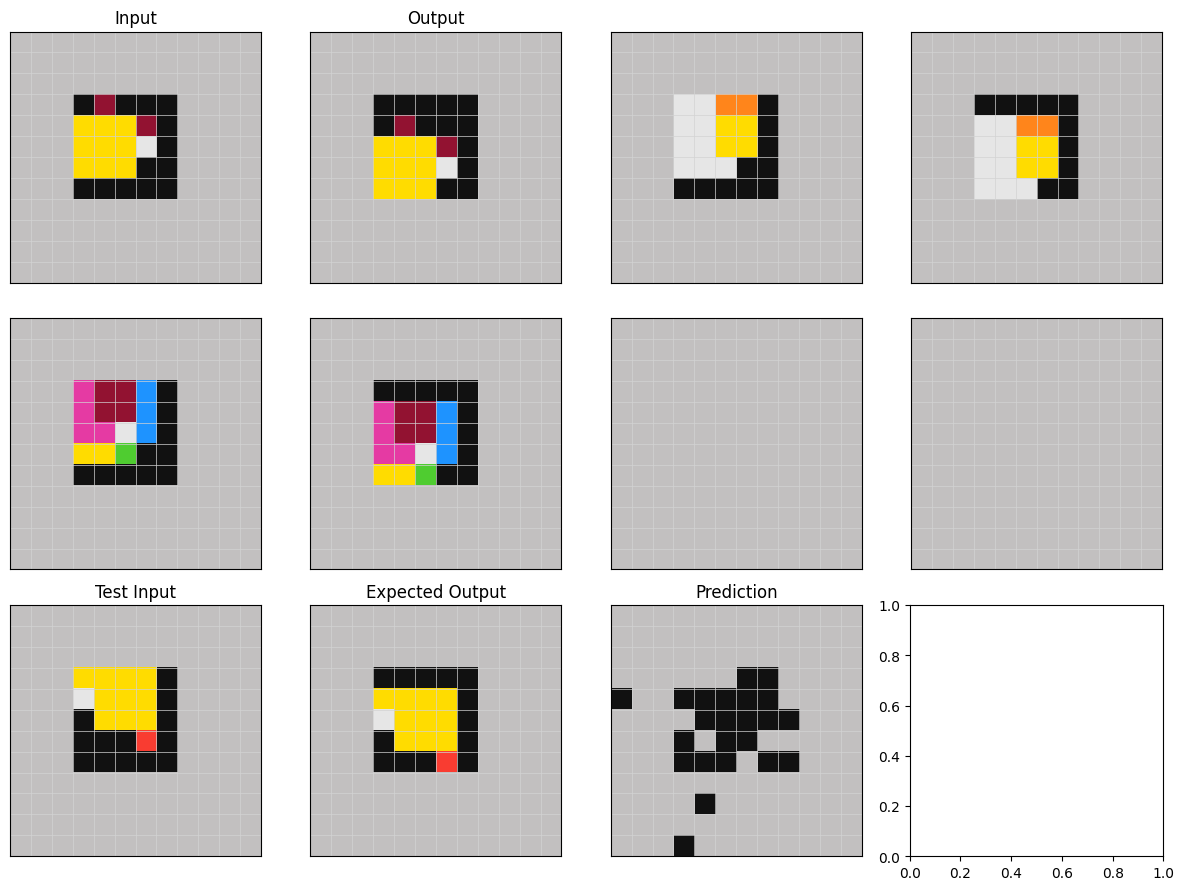

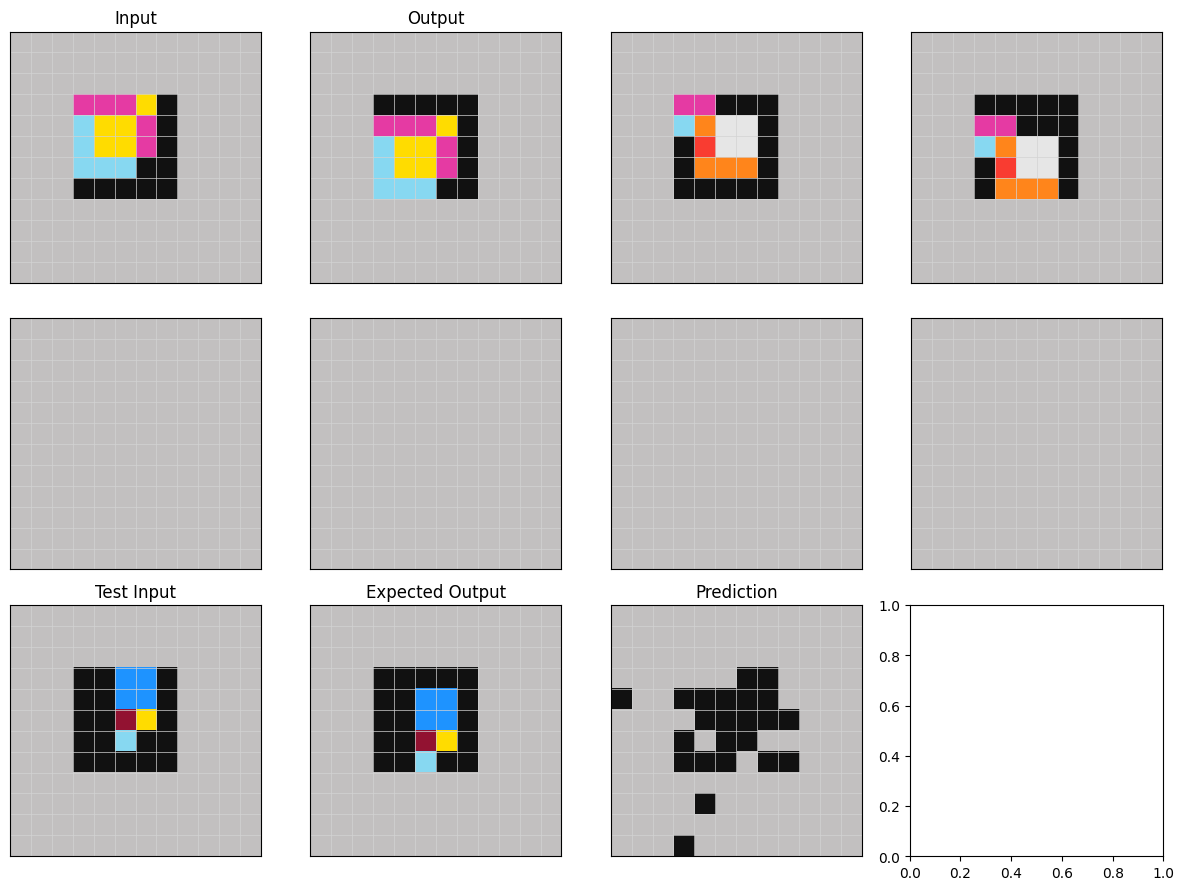

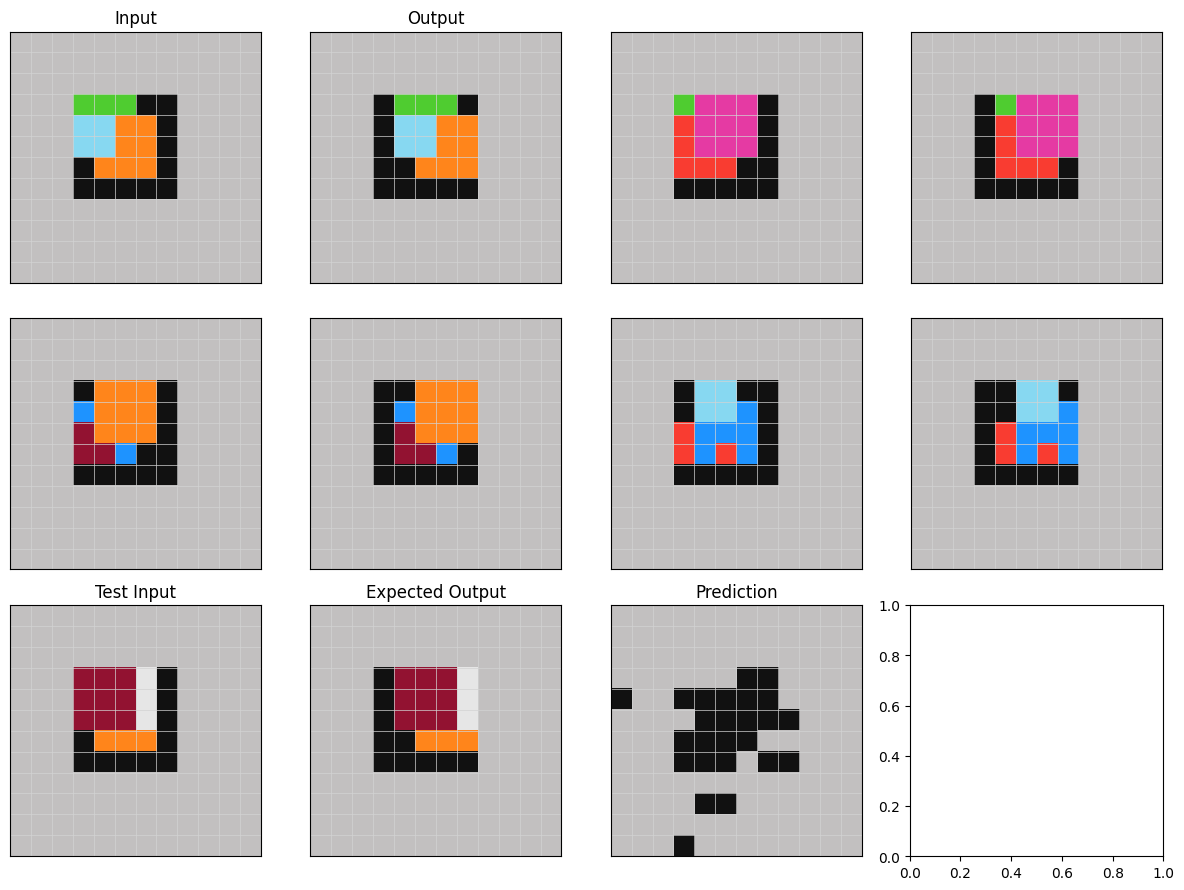

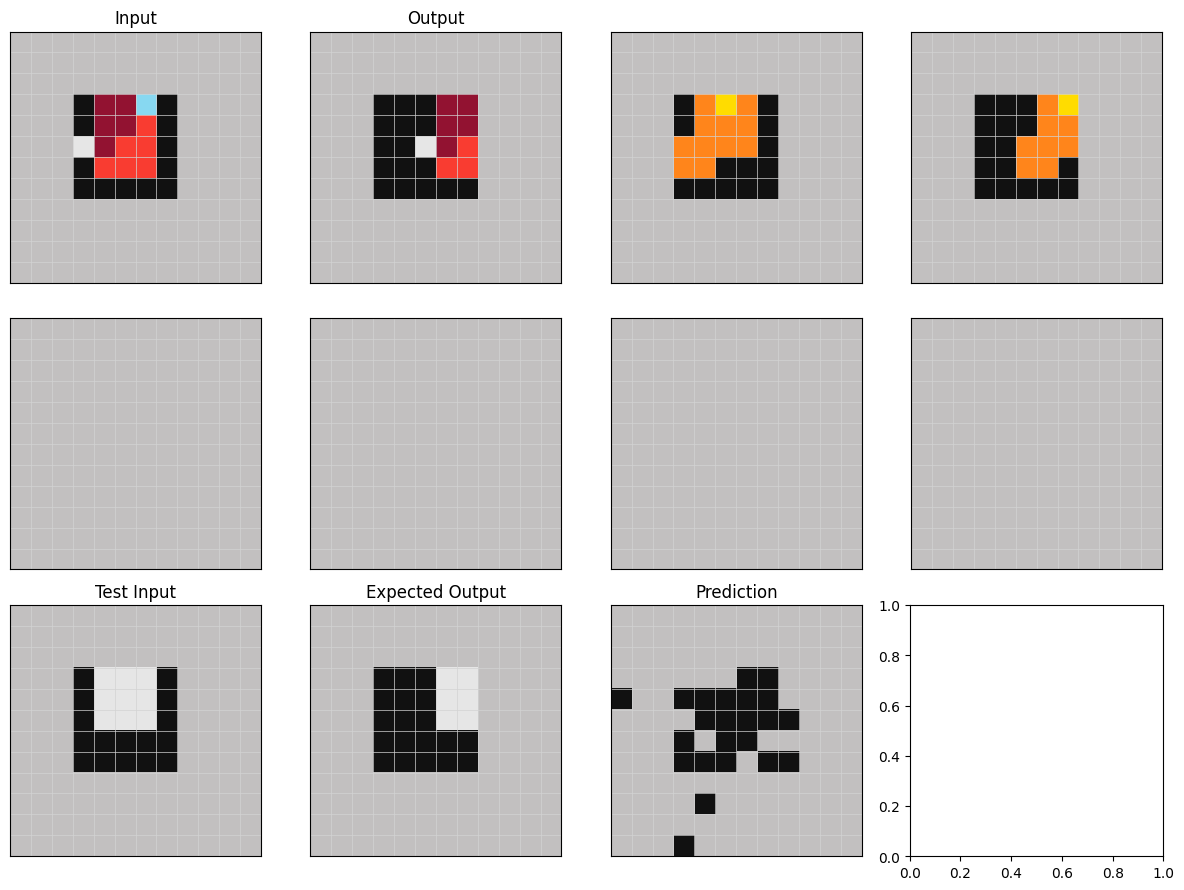

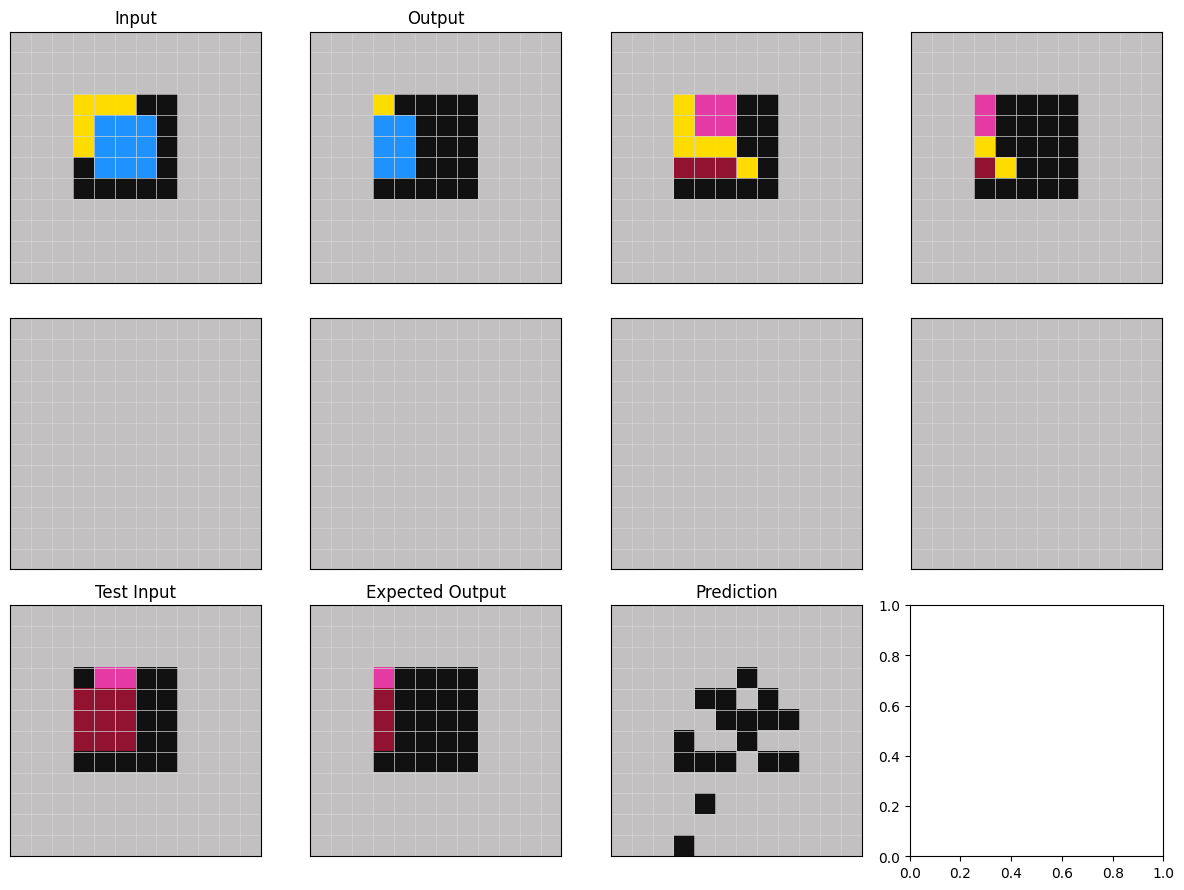

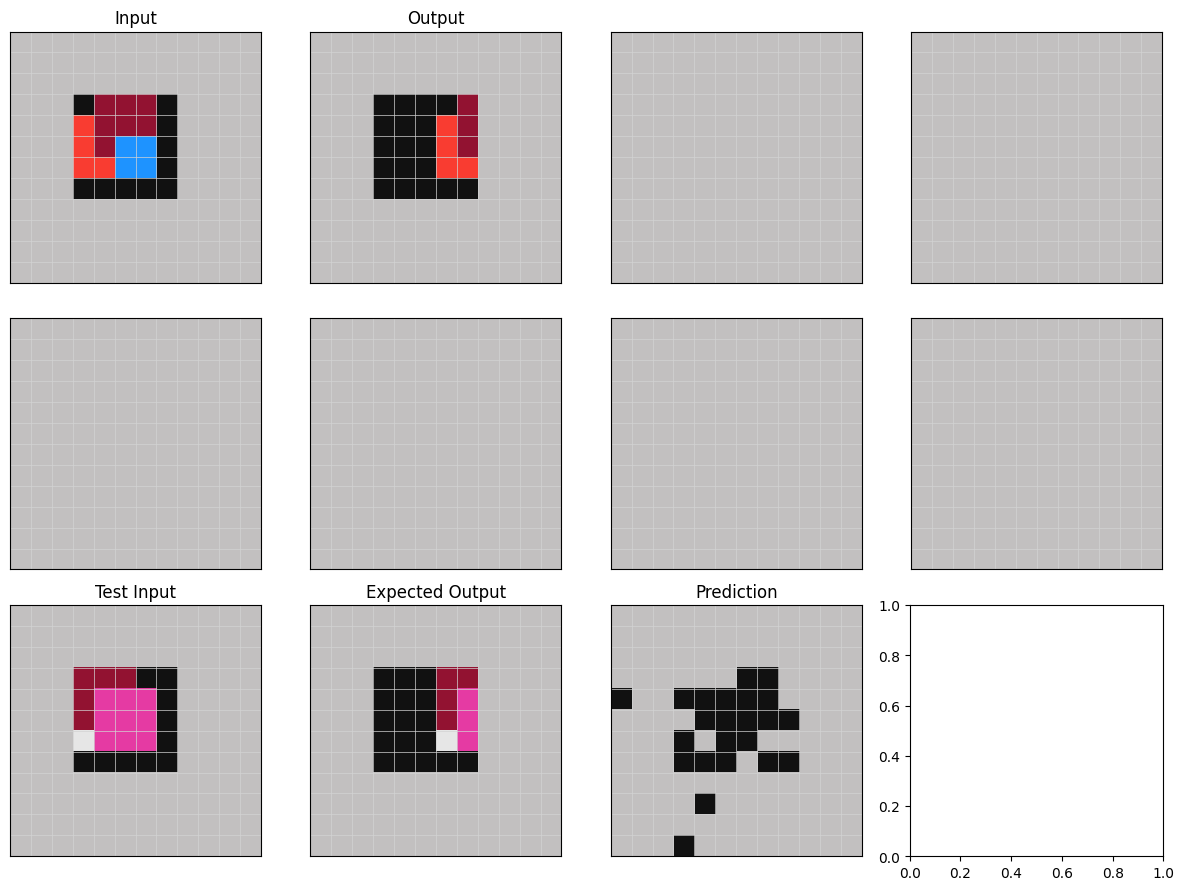

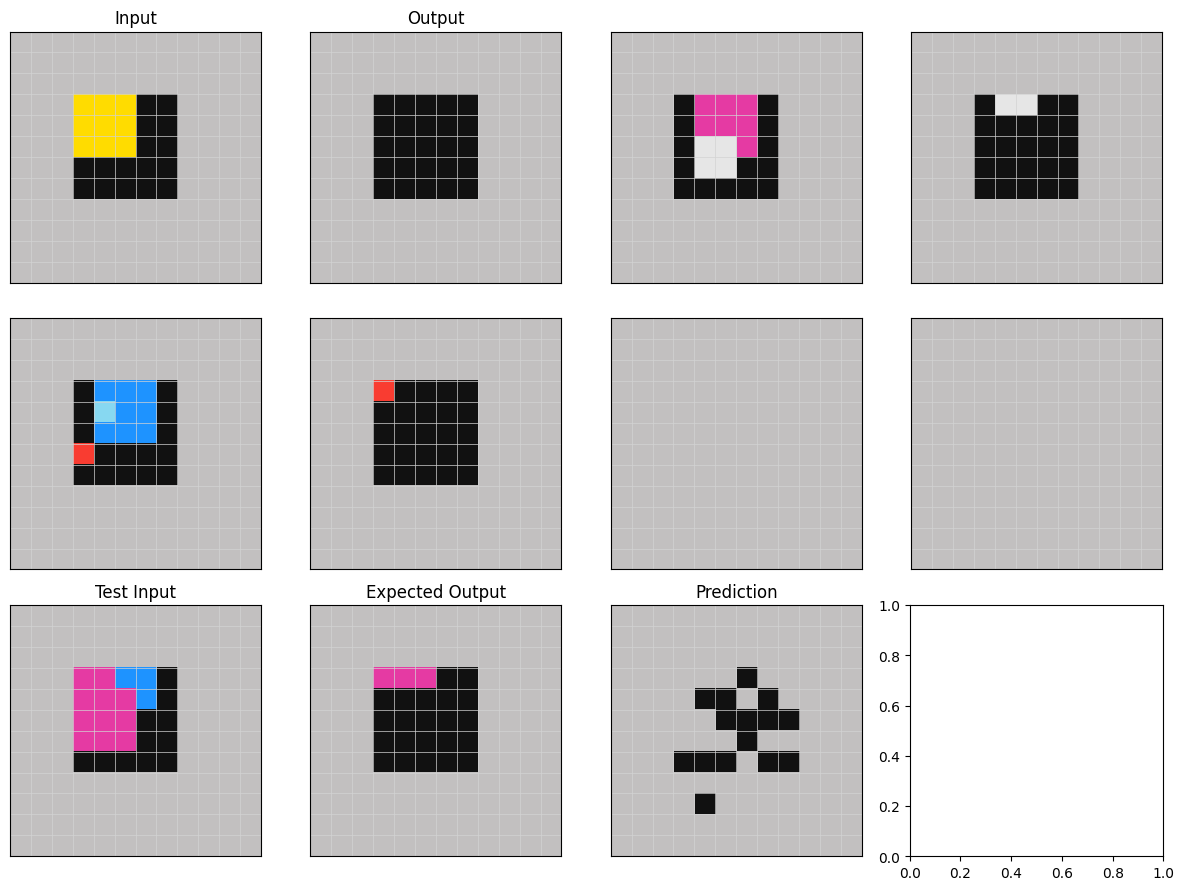

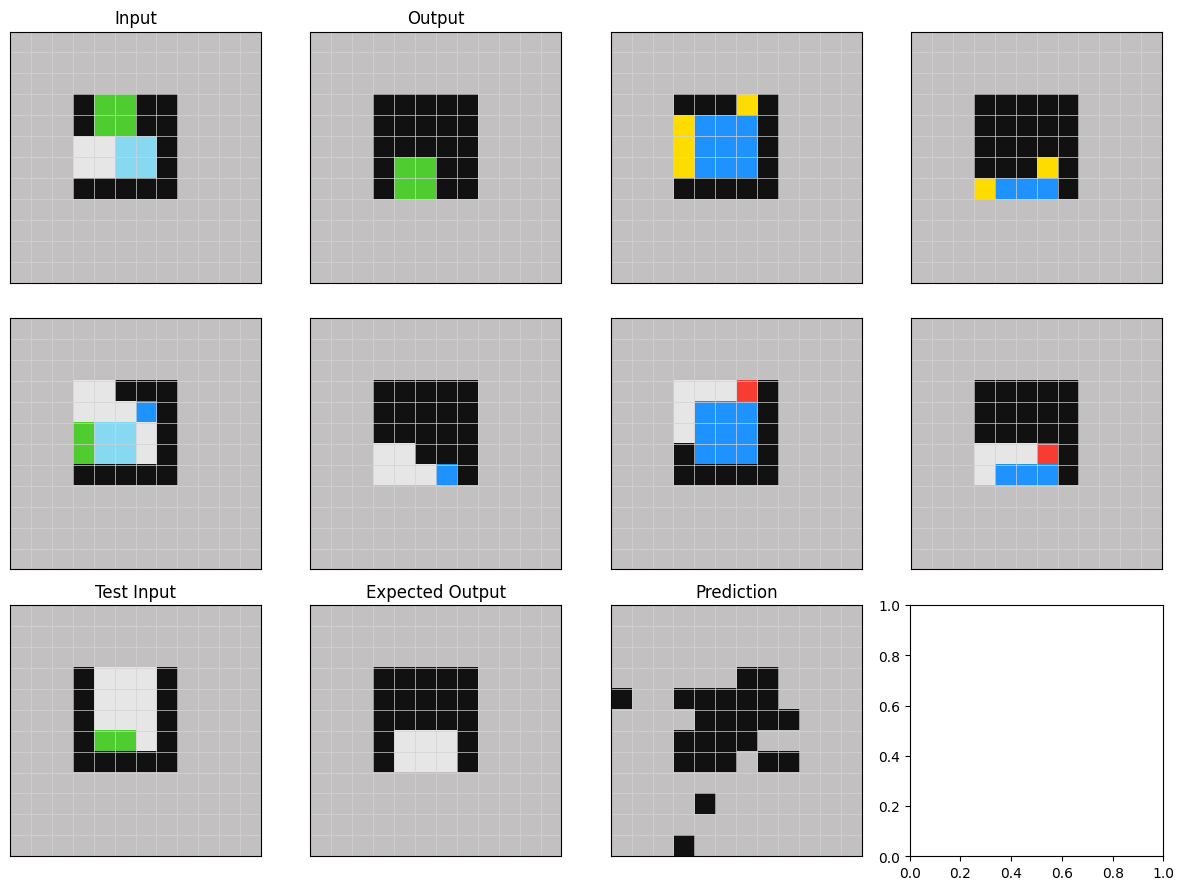

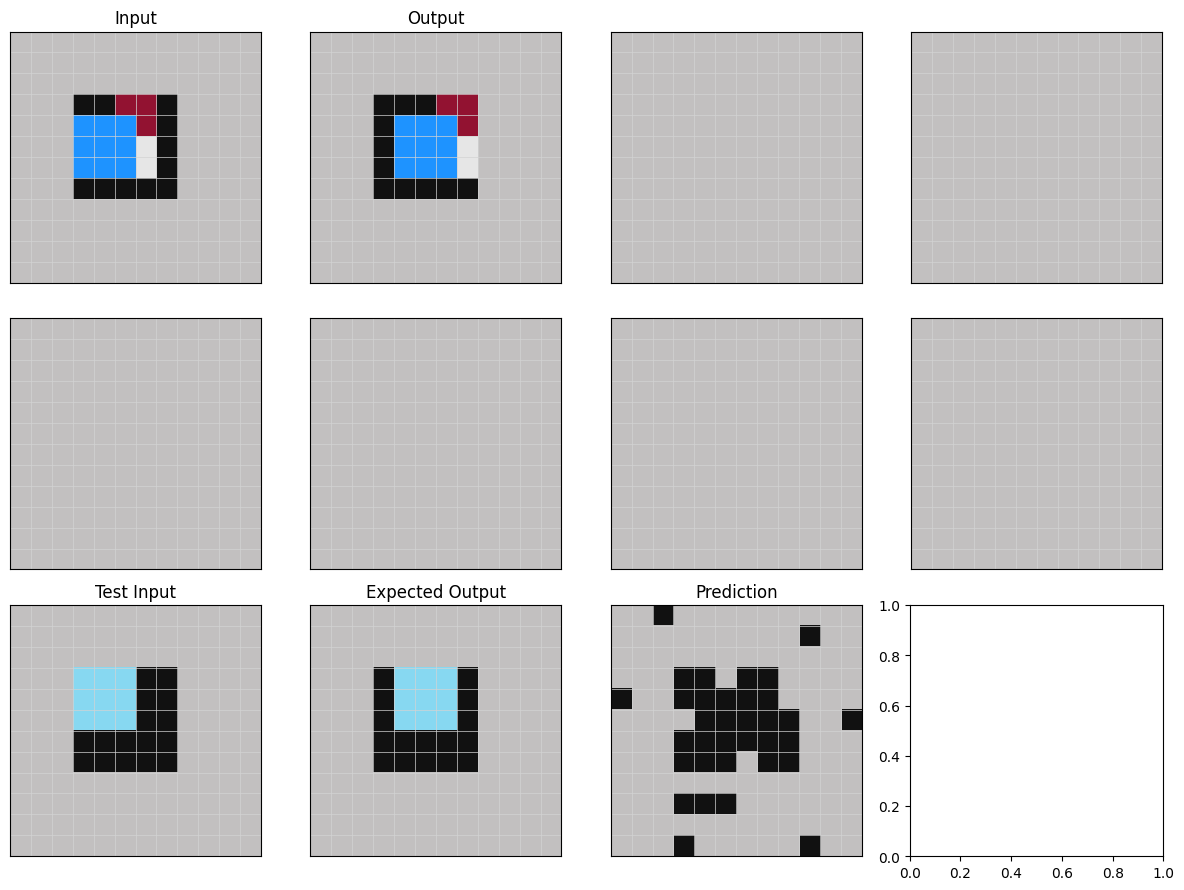

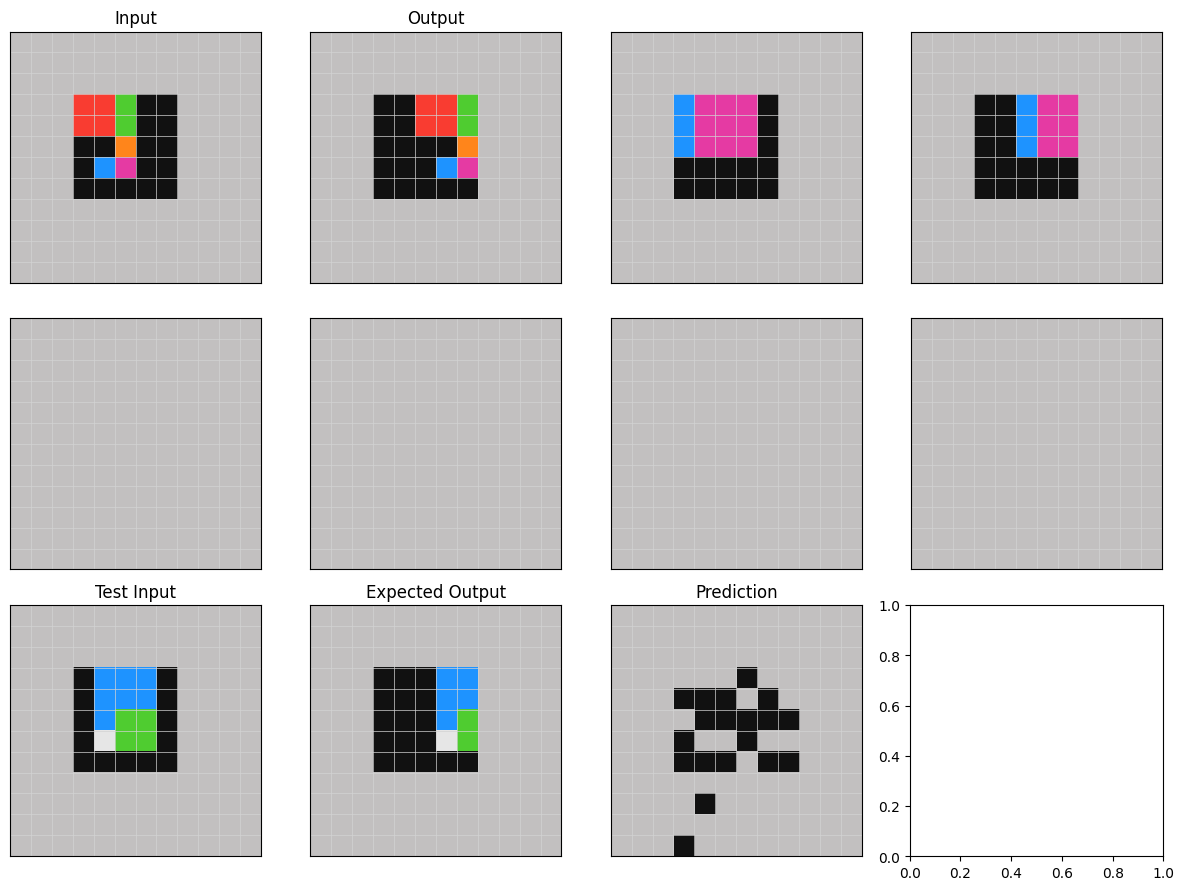

In [7]:

import matplotlib.pyplot as plt
from arc_prize.vis import visualize_tensors, visualize_all_heads
from arc_prize.vis import visualize_mean_mha_attention


def visualize_mean_attention(attention_weights: torch.Tensor, num_grids: int, grid_size: int):
    # Reshape the attention weights
    # From [4, 100, 900] to [4, 100, 9, 10, 10]
    num_heads = attention_weights.shape[0]
    reshaped_attention = attention_weights.view(
        num_heads, num_grids, grid_size, grid_size
    )

    # Calculate mean attention across the target sequence (dim=1)
    # mean_attention = reshaped_attention.mean(dim=1)  # Shape: [4, 9, 10, 10]
    mean_attention = reshaped_attention

    # Create a figure with subplots for each head
    fig, axes = plt.subplots(num_heads, num_grids, figsize=(20, 10))

    for head in range(num_heads):
        # Create a 3x3 grid of heatmaps
        for i in range(num_grids):
            grid_attention = mean_attention[head, i]

            # Add subplot within the head's subplot
            # sub_ax = ax.inset_axes([1/9])
            ax = axes[head, i]
            im = ax.imshow(grid_attention, cmap="viridis", interpolation="nearest")
            # ax.axis("off")

            if i == 0:
                ax.set_ylabel(f"Head {head + 1}", rotation=0, ha="right", va="center")

            # Add colorbar for each grid
            # plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # Remove ticks from the main subplot
        ax.set_xticks([])
        ax.set_yticks([])

    
    plt.tight_layout()
    plt.show()

for item in output:
#   if np.array_equal(item["output_grid"], item["predictions"]) is True:
    visualize_tensors(torch.Tensor(item["grids"]).squeeze(0), torch.Tensor(item["output_grid"]).squeeze(0), torch.Tensor(item["predictions"]).squeeze(0), None)
# print(torch.Tensor(item["decoder_sa_attn_weights"]).shape)
  # for i, layer in enumerate(torch.Tensor(item["decoder_mha_attn_weights"]).squeeze(0)):
  #   print(layer.shape)
  #   visualize_mean_attention(layer, 9, 30)
    

  # visualize_all_heads(layer, title=f"Layer {i}")
# for i, layer in enumerate(torch.Tensor(item["decoder_sa_attn_weights"]).squeeze(0)):
#     visualize_mean_sa_attention(layer)
    


In [ ]:
from dataclasses import dataclass
import torch


model_file_path = "models/subtly_known_panda.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_dict = torch.load(model_file_path, weights_only=False, map_location=device)
checkpoint = ARCModelState(**checkpoint_dict)

# ARCTransformerEncoderDecoderParams(grid_dim=12, num_train_pairs=4, num_colors=10, num_encoder_layers=6, num_decoder_layers=6, num_heads=16, d_model=512, d_ff=2048, dropout=0.3)

kaggle_model_file_path = "kaggle/models/subtly_known_panda.pth"
torch.save(checkpoint.model_state_dict, kaggle_model_file_path)
# kaggle_checkpoint = ARCKaggleModelState(model_params=checkpoint.model_params, model_state_dict=checkpoint.model_state_dict)



In [ ]:
def finalize_output(output: torch.Tensor) -> torch.Tensor:
    output = output - 1

    filtered_rows = [row[row != -1] for row in output]
    
    max_length = max(len(row) for row in filtered_rows)

    padded_rows = [torch.cat([row, torch.zeros(max_length - len(row), dtype=row.dtype, device=device)]) for row in filtered_rows]

    return torch.stack(padded_rows)

